# Rampart flats

This notebook's a convenient local development tool integrated with python interpreter, interactive browser-based text editor and preliminary started local PostgreSQL DB. Feel free to use this document to easily explore databases filled with [rampart](https://github.com/xXxRisingTidexXx/rampart) miners & parsers. Happy coding!

In [18]:
from warnings import filterwarnings
from pandas import read_csv, DataFrame
from numpy import array
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer
from seaborn import distplot
from matplotlib.pyplot import style, rcParams, subplots
from tabulate import tabulate
filterwarnings('ignore', message='numpy.dtype size changed')
filterwarnings('ignore', message='numpy.ufunc size changed')
%matplotlib inline
style.use('dark_background')
rcParams['figure.facecolor'] = '#111111'
rcParams['axes.facecolor'] = '#111111'
rcParams['axes.edgecolor'] = '#212121'
rcParams['axes.grid'] = True
rcParams['grid.color'] = '#212121'
rcParams['legend.frameon'] = False

<br />Lets load the whole *flats* table from the DB. Notice that the hostname equals the DB container name due to the common Docker network.

In [40]:
flats = read_csv('flats.csv', usecols=['origin_url', 'city', 'price', 'ssf', 'izf', 'gzf'])
flats = flats[flats['city'] == 'Київ']
flats.drop(columns=['city'], inplace=True)
flats['origin_url'] = flats['origin_url'].apply(lambda url: url[23:])

In [25]:
def render(df):
    print(tabulate(df, headers='keys', tablefmt='psql', numalign='right'))

In [41]:
render(flats.head())

+----+-----------------------------------------------------------------------------------------+---------+---------+----------+----------+
|    | origin_url                                                                              |   price |     ssf |      izf |      gzf |
|----+-----------------------------------------------------------------------------------------+---------+---------+----------+----------|
|  0 | realty-prodaja-kvartira-kiev-desnyanskiy-mariny-tsvetaevoy-ulitsa-17660593.html         |   82000 |       0 | 0.283735 | 0.398356 |
|  1 | realty-prodaja-kvartira-kiev-pecherskiy-ivana-kudri-ulitsa-17623869.html                |  249000 | 6.32589 |  2.45401 |  1.32433 |
|  2 | realty-prodaja-kvartira-kiev-pecherskiy-makkeyna-djona-ivana-kudri-ulitsa-17649808.html |  178000 | 6.32589 |  2.45401 |  1.32433 |
|  3 | realty-prodaja-kvartira-kiev-leyptsigskaya-ulitsa-17289915.html                         |  109000 | 6.24875 |  4.24788 |  6.15581 |
|  4 | realty-prodaja-kvart

In [42]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837 entries, 0 to 3306
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin_url  1837 non-null   object 
 1   price       1837 non-null   int64  
 2   ssf         1837 non-null   float64
 3   izf         1837 non-null   float64
 4   gzf         1837 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 86.1+ KB


In [43]:
render(flats.describe())

+-------+---------+---------+----------+----------+
|       |   price |     ssf |      izf |      gzf |
|-------+---------+---------+----------+----------|
| count |    1837 |    1837 |     1837 |     1837 |
| mean  |  209032 | 4.83826 |  2.68741 |  2.39328 |
| std   |  312244 | 5.99778 |  4.28019 |  3.37421 |
| min   |   23000 |       0 |        0 |        0 |
| 25%   |   80000 | 1.28314 | 0.846678 | 0.625552 |
| 50%   |  125000 | 3.28904 |  1.96483 |  1.22437 |
| 75%   |  233000 | 6.71239 |  3.23379 |  3.14345 |
| max   | 4.5e+06 | 57.3019 |   60.152 |  58.2086 |
+-------+---------+---------+----------+----------+


<br />Now it's the very time to explore the numerical data.

In [44]:
features = ['price', 'ssf', 'izf', 'gzf']
scores = [flats[features]]
scaler = MinMaxScaler()
scaler.fit(scores[0])
scores.append(DataFrame(scaler.transform(scores[0]), columns=features))

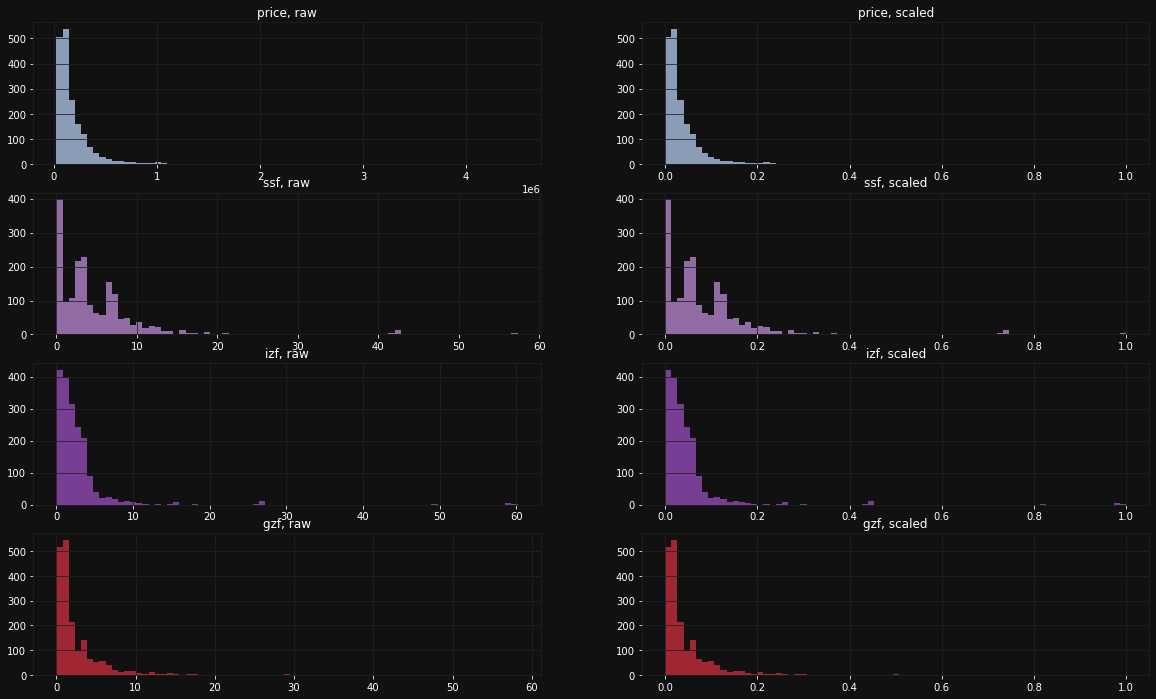

In [45]:
kinds = ['raw', 'scaled']
colors = ['#c0d8ff', '#ca95e5', '#a352cc', '#e02f44']
figure, axes = subplots(len(features), len(kinds), figsize=(20, 12))
for i in range(len(features)):
    for j in range(len(kinds)):
        axes[i, j].set_title(f'{features[i]}, {kinds[j]}')
        distplot(
            scores[j][features[i]], 
            ax=axes[i, j], 
            color=colors[i], 
            kde=False, 
            bins=75, 
            axlabel=False, 
            hist_kws={'alpha': 0.7}
        )

<br /> And now let's calculate distances by different metrics.

In [48]:
def topk(dataframe):
    render(dataframe.sort_values('distance').head(20))

In [51]:
candidates, preferences = scores[1], scaler.transform(array([[60000, flats['ssf'].max(), 0, flats['gzf'].max()]]))
weights = array([1, 0.2, 0.2, 0.2])
cosine = flats.copy()
cosine['distance'] = cdist(candidates, preferences, 'cosine', w=weights)
topk(cosine)
euclidean = flats.copy()
euclidean['distance'] = cdist(candidates, preferences, 'euclidean', w=weights)
topk(euclidean)

+------+--------------------------------------------------------------------------------------+---------+---------+----------+---------+------------+
|      | origin_url                                                                           |   price |     ssf |      izf |     gzf |   distance |
|------+--------------------------------------------------------------------------------------+---------+---------+----------+---------+------------|
| 1180 | realty-prodaja-kvartira-kiev-goloseevskiy-vasilkovskaya-ulitsa-17585752.html         |   60000 | 14.0635 | 0.268801 | 15.3876 | 0.00149032 |
| 3160 | realty-prodaja-kvartira-kiev-goloseevskiy-vasilkovskaya-ulitsa-17344332.html         |   65000 | 14.0635 | 0.268801 | 15.3876 | 0.00177684 |
| 2073 | realty-prodaja-kvartira-kiev-goloseevskiy-17217466.html                              |   32000 | 3.17669 |  0.20178 | 2.94802 | 0.00309898 |
| 1373 | realty-prodaja-kvartira-kiev-goloseevskiy-akademika-zabolotnogo-ulitsa-16889906.html |   61